# Deep learning particle identification

We are going to combine a multi-level perceptron with a LSTM (Long Short Term Memory) layer, in order to distinguish between conversion electrons and cosmic rays using hits information in the Mu2e experiment. LSTMs are used for text recognition and categorization, where the correlation between words are important. Here, we exploit this feature to teach our network the correlations between different hits in the same track.

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

from tqdm.keras import TqdmCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler

from deepid import deepid, plotter

params = {
    'axes.prop_cycle': plt.cycler(color=plt.cm.Set2.colors),
    'axes.labelsize': 'x-large',
    'legend.fontsize': 'large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'large',
    'ytick.labelsize': 'large',
    'legend.title_fontsize': 'large'
}
plt.rcParams.update(params)

In [2]:
global_vars = ['DeltaE', 'ClusterLength', 'RPOCA', 'TrackDirection', 'DeltaT']

In [3]:
!wget https://portal.nersc.gov/project/m3712/data/deepid/crymix.root

--2022-06-01 15:14:27--  https://portal.nersc.gov/project/m3712/data/deepid/crymix.root
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.108, 128.55.206.109, 128.55.206.112, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 331740653 (316M)
Saving to: ‘crymix.root.2’

crymix.root.2       100%[===================>] 316.37M   146MB/s    in 2.2s    

2022-06-01 15:14:29 (146 MB/s) - ‘crymix.root.2’ saved [331740653/331740653]



In [4]:
with uproot.open("crymix.root") as file_cry:
    trkananeg_cry = file_cry["TrkAnaNeg"]["trkana"]
    cry = trkananeg_cry.arrays(filter_name="/de|dm|demc|detrkpid|detsh._edep|detsh._dx|detsh._resid|detsh._plane|ue|deent/i")

In [5]:
!wget https://portal.nersc.gov/project/m3712/data/deepid/cemix.root

--2022-06-01 15:14:36--  https://portal.nersc.gov/project/m3712/data/deepid/cemix.root
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.108, 128.55.206.109, 128.55.206.112, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 534039888 (509M)
Saving to: ‘cemix.root.2’

cemix.root.2        100%[===================>] 509.30M   142MB/s    in 3.9s    

2022-06-01 15:14:40 (131 MB/s) - ‘cemix.root.2’ saved [534039888/534039888]



In [6]:
with uproot.open("cemix.root") as file_ce:
    trkananeg_ce = file_ce["TrkAnaNeg"]["trkana"]
    ce = trkananeg_ce.arrays(filter_name="/de|dm|demc|detrkpid|detsh._edep|detsh._dx|detsh._resid|detsh._plane|ue|deent/i")

In [7]:
n_events = min(len(ce),len(cry))
cry_target = np.zeros(n_events)
ce_target = np.full(n_events, 1)
target = np.concatenate((ce_target, cry_target))
n_bins = 200

In [8]:
scaler = StandardScaler()
new_vars = global_vars.copy()
new_vars.append("dedx")
new_vars.append("redchisq")
new_vars.append("muredchisq")

In [9]:
df_full, global_full, dedx_full, residual_full, plane_full = deepid.prepare_dataset(ak.concatenate((ce[:n_events], cry[:n_events])), scaler, global_vars, n_bins=n_bins, fit=True)

## MLP network

The goal of the model is to combine the discrimination power of the high-level, fixed-length features with the low-level, variable-length ones. Here we train a multilayer perceptron (MLP) using the 8 high-level features as input. The MLP consists of two fully connected (or _dense_) layers of 64 neurons with ReLU activation and one output layer with softmax activation. After each of the two intermediate layers a dropout with a rate of 0.2 is applied for regularization. 

In [10]:
x_global_train, x_global_test, y_global_train, y_global_test = train_test_split(global_full, target, test_size=0.5, random_state=42)
x_global_test, x_global_valid, y_global_test, y_global_valid = train_test_split(x_global_test, y_global_test, test_size=0.5, random_state=42)

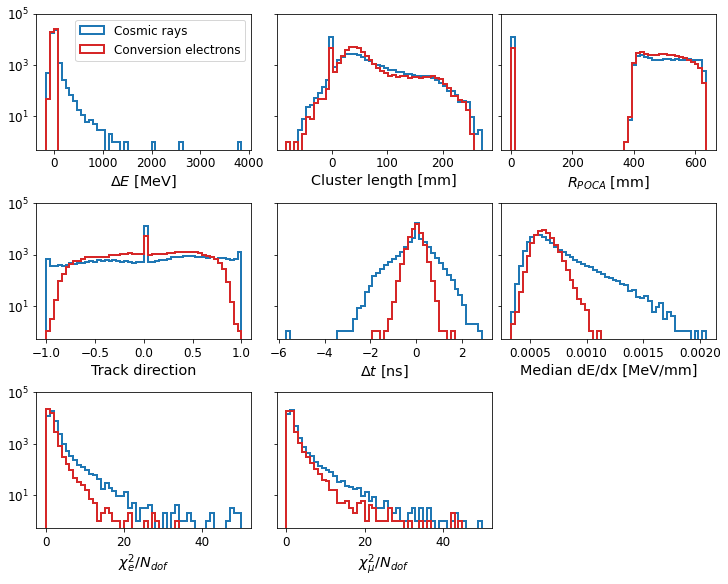

In [11]:
titles = [r"$\Delta E$ [MeV]", "Cluster length [mm]", r"$R_{POCA}$ [mm]", "Track direction", 
          r"$\Delta t$ [ns]", "Median dE/dx [MeV/mm]", r"$\chi^2_e/N_{dof}$",  r"$\chi^2_{\mu}/N_{dof}$"]

fig, axs = plt.subplots(3,3,figsize=(10,8), constrained_layout=True, sharey=True)

for i,var in enumerate(new_vars):
    ix = i // 3
    iy = i % 3
    x_min = min(df_full[var])
    x_max = max(df_full[var])
    
    if "chi" in var: 
        x_min, x_max = 0, 50

    axs[ix][iy].hist(df_full[n_events:][var], range=(x_min, x_max), bins=50, histtype='step', lw=2, label="Cosmic rays", color='tab:blue')
    axs[ix][iy].hist(df_full[:n_events][var], range=(x_min, x_max), bins=50, histtype='step', lw=2, label="Conversion electrons", color='tab:red')
    axs[ix][iy].set_xlabel(titles[i])
    axs[ix][iy].set_yscale("log")
    axs[ix][iy].set_ylim(0.5,1e5)
    if i == 0:
        axs[ix][iy].legend()
        
axs[-1][-1].axis("off")
fig.savefig("highlevel.pdf")

In [12]:
n_variables = x_global_train.shape[1]

this_global = deepid.model_global(n_variables)

history_global = this_global.fit(x_global_train, y_global_train,
                                 epochs=90,
                                 verbose=0,
                                 validation_data=(x_global_valid, y_global_valid),
                                 callbacks=[TqdmCallback(verbose=1)])

2022-06-01 15:16:50.008946: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

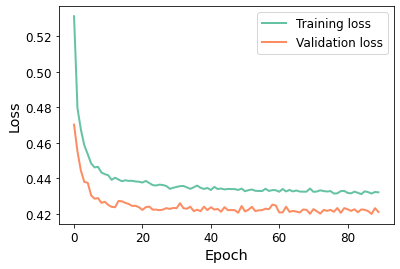

In [13]:
fig, ax = plt.subplots(1,1)
ax.plot(history_global.history['loss'], label="Training loss", lw=2)
ax.plot(history_global.history['val_loss'], label="Validation loss", lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig("global_loss.pdf")

In [14]:
prediction_global = this_global.predict(x_global_test)

In [15]:
fpr_global_test, tpr_global_test, th_global_test = roc_curve(y_global_test, prediction_global.ravel())
auc_global_test = roc_auc_score(y_global_test, prediction_global.ravel())

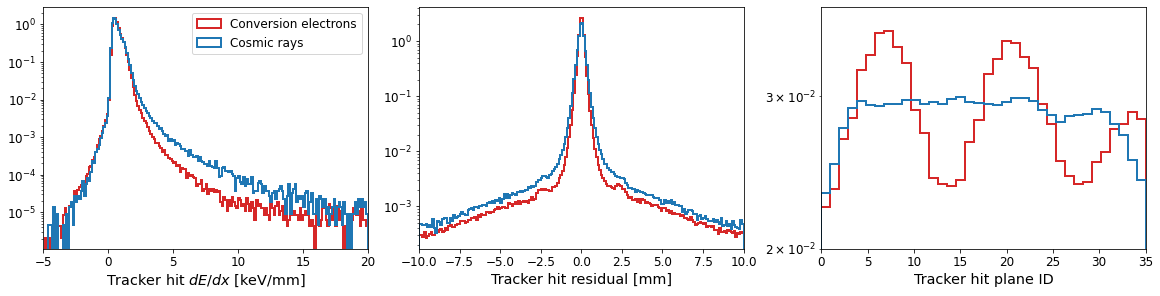

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16,4), constrained_layout=True)

mask_ce = ce['detsh._dx']>0
mask_cry = cry['detsh._dx']>0

_=ax[0].hist(np.concatenate((ce['detsh._edep'][mask_ce]/ce['detsh._dx'][mask_ce]))*1000, 
             range=(-0.005*1000, 0.02*1000), bins=n_bins, label="Conversion electrons", histtype='step', lw=2, color='tab:red',density=True)
_=ax[0].hist(np.concatenate((cry['detsh._edep'][mask_cry]/cry['detsh._dx'][mask_cry]))*1000, 
             range=(-0.005*1000, 0.02*1000), bins=n_bins, label="Cosmic rays", histtype='step', lw=2, color='tab:blue',density=True)

_=ax[1].hist(np.concatenate(ce['detsh._resid'][mask_ce]), range=(-10,10), bins=n_bins, histtype='step', lw=2, color='tab:red', density=True)
_=ax[1].hist(np.concatenate(cry['detsh._resid'][mask_cry]), range=(-10,10), bins=n_bins, histtype='step', lw=2, color='tab:blue', density=True)

_=ax[2].hist(np.concatenate(ce['detsh._plane'][mask_ce]), range=(0,36), bins=37, histtype='step', color='tab:red', lw=2, density=True)
_=ax[2].hist(np.concatenate(cry['detsh._plane'][mask_cry]), range=(0,36), bins=37, histtype='step', color='tab:blue', lw=2, density=True)

ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")


ax[0].legend()
ax[0].set_xlabel(r"Tracker hit $dE/dx$ [keV/mm]")
ax[1].set_xlabel(r"Tracker hit residual [mm]")
ax[2].set_xlabel(r"Tracker hit plane ID")
ax[0].set_xlim(-0.005*1000, 0.02*1000)
ax[1].set_xlim(-10,10)
ax[2].set_ylim(0.02, 0.038)
ax[2].set_xlim(0,35)
fig.savefig("sequences.pdf")

## LSTM networks
Simple dense deep neural network are not suitable for processing variable length sequences of inputs. Recurrent neural networks (RNNs) are a class of neural networks which use their internal state (memory) to handle sequential data of arbitrary size. Long short-term memory networks (LSTMs) are a particular type of RNN which address the _vanishing gradient problem_ affecting classic RNNs. Here we train three separate networks containing LSTMs using as input the hits $dE/dx$, residuals, and plane ID.  

### dE/dx

In [ ]:
samples, model_dedx, history_dedx, fpr_dedx, tpr_dedx, auc_dedx, dedx_prediction = deepid.run_network(dedx_full, 
                                                                                                      target, 
                                                                                                      epochs=5)
x_dedx_train, x_dedx_test, x_dedx_valid, y_dedx_train, y_dedx_test, y_dedx_valid = samples

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
fpr_dedx_test, tpr_dedx_test, th_dedx_test = roc_curve(y_global_test, dedx_prediction.ravel())
auc_dedx_test = roc_auc_score(y_global_test, dedx_prediction.ravel())

In [ ]:
fig,ax =plt.subplots(1,1)
ax.plot(history_dedx.history['loss'], label="Training loss", lw=2)
ax.plot(history_dedx.history['val_loss'], label="Validation loss", lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig("dedx_loss.pdf")

### Plane ID

In [ ]:
samples, model_plane, history_plane, fpr_plane, tpr_plane, auc_plane, plane_prediction = deepid.run_network(plane_full, 
                                                                                                            target,
                                                                                                            epochs=5)
x_planes_train, x_planes_test, x_planes_valid, y_planes_train, y_planes_test, y_planes_valid = samples

In [ ]:
fpr_plane_test, tpr_plane_test, th_plane_test = roc_curve(y_global_test, plane_prediction.ravel())
auc_plane_test = roc_auc_score(y_global_test, plane_prediction.ravel())

In [ ]:
!pwd

In [ ]:
fig,ax =plt.subplots(1,1)
ax.plot(history_plane.history['loss'], label="Training loss", lw=2)
ax.plot(history_plane.history['val_loss'], label="Validation loss", lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
fig.savefig("dedx_loss.pdf")

### Residuals

In [ ]:
samples, model_res, history_res, fpr_res, tpr_res, auc_res, res_prediction = deepid.run_network(residual_full, 
                                                                                                target, 
                                                                                                epochs=5)
x_res_train, x_res_test, x_res_valid, y_res_train, y_res_test, y_res_valid = samples

In [ ]:
fpr_res_test, tpr_res_test, th_res_test = roc_curve(y_global_test, res_prediction.ravel())
auc_res_test = roc_auc_score(y_global_test, res_prediction.ravel())

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(history_res.history['val_loss'])

In [ ]:
multi = np.stack((x_dedx_train, x_res_train, x_planes_train),axis=1)
multi_test = np.stack((x_dedx_test, x_res_test, x_planes_test),axis=1)
multi_valid = np.stack((x_dedx_valid, x_res_valid, x_planes_valid),axis=1)

embedding_size = 64
maxlen = 50
this_deepid = deepid.model_deepid(n_bins, n_variables, embedding_size, maxlen)
history_deepid = this_deepid.fit([multi, x_global_train],
                                 y_global_train,
                                 verbose=0,
                                 callbacks=[TqdmCallback(verbose=1)],
                                 validation_data=([multi_valid, x_global_valid], y_global_valid),
                                 epochs=3)

In [ ]:
prediction_deepid = this_deepid.predict([multi_test, x_global_test])

In [ ]:
fpr_deepid_test, tpr_deepid_test, th_deepid_test = roc_curve(y_global_test, prediction_deepid.ravel())
auc_deepid_test = roc_auc_score(y_global_test, prediction_deepid.ravel())

## Testing on mock data sample

Here we apply the models we have trained to a mock data sample which corresponds to approximately one week of data taking with a $\mu\rightarrow e$ conversion to muon capture ratio of $R_{\mu e} = 1.6\times10^{-13}$. 

In [ ]:
!wget https://portal.nersc.gov/project/m3712/data/deepid/run7.root

In [ ]:
run7_file = uproot.open("run7.root")['TrkAnaNeg']['trkana']
run7 = run7_file.arrays(filter_name="/de|dm|demc|detrkpid|detsh._edep|detsh._dx|detsh._resid|detsh._plane|ue|deent/i")

In [ ]:
df_run7, global_run7, dedx_run7, res_run7, plane_run7 = deepid.prepare_dataset(run7, scaler, global_vars, n_bins=n_bins)

In [ ]:
prediction_global_run7 = this_global.predict(global_run7)
df_run7['global_nn'] = prediction_global_run7

In [ ]:
prediction_deepid_run7 = this_deepid.predict([np.stack([dedx_run7, res_run7, plane_run7], axis=1), global_run7])
df_run7['deepid'] = prediction_deepid_run7

In [ ]:
df_run7['weight'] = 1

In [ ]:
cuts_run7 = (df_run7['de_status' ]> 0) & \
            (df_run7['t0'] > 700) & \
            (df_run7['t0'] < 1695) & \
            (df_run7['td'] > 0.577350) & \
            (df_run7['td'] < 1) & \
            (df_run7['d0'] > -80) & \
            (df_run7['d0'] < 105) & \
            (df_run7['d0']+2/df_run7['om'] > 450) & (df_run7['d0']+2/df_run7['om'] < 680) & \
            (df_run7['ue_status']<=0) & \
            (df_run7['mom']>95)# & \

In [ ]:
samples = {'mc': df_run7[cuts_run7]}
weights = {'mc': 1}

my_plotter = plotter.Plotter(samples, weights)

In [ ]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4), sharey=True)
my_plotter.plot_variable(ax[0],
                         "deepid",
                         title="DeePID score",
                         cat_var="gen",
                         query="mom>0",
                         x_range=(0,1),
                         bins=50)
ax[0].set_yscale('log')
ax[0].set_ylim(bottom=0.5)

my_plotter.plot_variable(ax[1],
                         "global_nn",
                         title="MLP score",
                         cat_var="gen",
                         query="mom>0",
                         x_range=(0,1),
                         bins=50)
ax[1].set_yscale('log')
ax[1].set_ylim(bottom=0.5, top=1e6)
ax[1].set_ylabel("")
ax[1].get_legend().remove()
fig.savefig("scores.pdf")

In [ ]:
deepid_cut = 0.9
global_cut = 0.9

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10,4), sharey=True, sharex=True)
my_plotter.plot_variable(ax[0],
                         "mom",
                         title="Momentum [MeV]",
                         cat_var="gen",
                         query=f"mom>0&deepid>{deepid_cut}",
                         x_range=(95,110),
                         plot_range=(102,105),
                         bins=30)
ax[0].set_title(f"DeePID > {deepid_cut}")

my_plotter.plot_variable(ax[1],
                         "mom",
                         title="Momentum [MeV]",
                         cat_var="gen",
                         query=f"mom>0&global_nn>{global_cut}",
                         x_range=(95,110),
                         plot_range=(102,105),
                         bins=30)

ax[1].set_ylabel("")
ax[1].set_ylim(0.5, 1e3)
ax[0].set_yscale('log')
ax[1].set_title(f"MLP > {global_cut}")
fig.savefig("run7.pdf")

In [ ]:
muon_savedout = df_full.query('gen==38')['trkpid']
electron_savedout = df_full.query('gen==2')['trkpid']
y_saved_muon = [0]*len(muon_savedout)
y_saved_electron = [1]*len(electron_savedout)
saved_out = np.concatenate((muon_savedout, electron_savedout))
y_saved = np.concatenate((y_saved_muon, y_saved_electron))

fpr_trkpid, tpr_trkpid, th_trkpid = roc_curve(y_saved, saved_out)
auc_trkpid = roc_auc_score(y_saved,saved_out)

In [ ]:
fig, ax = plt.subplots(1,1, constrained_layout=True, figsize=(5.5,5.5))

ax.plot(tpr_deepid_test, 1-fpr_deepid_test, label=f'DeePID model: {auc_deepid_test:.3g} AUC', lw=2)
ax.plot(tpr_global_test, 1-fpr_global_test, label=f'MLP model: {auc_global_test:.3g} AUC', lw=2)
ax.plot(tpr_plane_test, 1-fpr_plane_test, label=f'Plane model: {auc_plane:.3g} AUC', lw=2)
ax.plot(tpr_dedx_test, 1-fpr_dedx_test, label=f'dE/dx model: {auc_dedx:.3g} AUC', lw=2)
ax.plot(tpr_res_test, 1-fpr_res_test, label=f'Residual model: {auc_dedx:.3g} AUC', lw=2)
ax.plot(tpr_trkpid, 1-fpr_trkpid, label=f'TrkPID model: {auc_trkpid:.3g} AUC', lw=2)


ax.set_xlabel("True positive rate (signal efficiency)")
ax.set_ylabel("1 - False positive rate (background rejection)")
ax.set_xlim(0,1.02)
ax.set_ylim(0,1.02)
ax.legend()
fig.savefig("roc.pdf")